# Example 4 - Quantum Monte Carlo

The study of quantum statistics in polariton condensates is pivotal as it delves into the quantum features of light-matter systems, revealing the transition from incoherent thermal states to coherent states, which is essential for advancing quantum protocols and technologies.

The Monte Carlo approach is instrumental in simulating the dynamics of polariton condensates, providing a robust framework to analyze phase and intensity fluctuations, and thereby quantifying the quantum coherence present within these complex systems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import time
from collections import defaultdict
from scipy.special import iv as besselfunction
from pyphoenix import pyphoenix

# System Parameters
grid_size = 256                  # Grid Size, int this case 200x200
x_max = 230.4                    # mum; Maximum Distance in one direction, meaning the grid will be from -10mum to 10mum
effective_mass = 5.6856E-4       # kg; Effective Mass of the electron, scaled
gamma_c = 0.2                    # Polariton Loss Rate
gamma_r = 1.5 * gamma_c          # Reservoir Loss Rate
R = 0.015                        # Condensation Rate
g_c = 6E-6                       # Polariton-Polariton Coupling
g_r = 2*g_c                      # Polariton-Reservoir Coupling
t_step = 0.04                    # ps; Time step of the simulation

# Special Parameters for this example
pump_amp_factor = gamma_c*gamma_r/R   # Pump Amplitude
pump_sigma = 65*np.sqrt(0.5)          # Pump Sigma
pump_power = 2                        # Pump Power

# Additional Parameters not required by PHOENIX:
hbar = 6.582119569E-4
dx = x_max/grid_size

# Matrix Generation

In this example, we are fine with using PHOENIX's ability to generate spacial shapes via its envelope syntax.


# Run a Simulation with PHOENIX

We also plot the test calculation. The density for the given set of parameters should approach zero.

Because we want a statistical evaluation incorporating noise in every timestep, we use `--dw 1` to enable noise at a scale of 1.

In [20]:
# Runstring generator
def run( *, t_max: float, output_suffix: str = None, pump_amp: float = 1, history_matrix: bool = True):
    # define simulation parameters with a dict
    config={
        "N":[grid_size,grid_size],  # Set the grid size in points
        "L":[x_max,x_max],          # Set the grid size in mum
        "hbarscaled": hbar,         # Set the scaled reduced Planck constant
        "meff":effective_mass,      # Set the effective mass
        "tmax":t_max,               # Set the end time  
        "tstep":t_step,             # Set the time step
        "outEvery": 5,              # Set sample rate 
        "gc":g_c,                   # Set the coupling constants
        "gr":g_r,                   # Set the coupling constants
        "R":R,                      # Set the condensation rate
        "gammaR": gamma_r,          # Set the reservoir loss rate
        "gammaC": gamma_c,          # Set the polariton loss rate
        "boundary": ["periodic","periodic"], # Set periodic boundary conditions in both directions
        "fftEvery": 5,              # Set the FFT sample rate
    }
    # Add pump 
    config["pump"]=[pump_amp*pump_amp_factor,"add",pump_sigma,pump_sigma,0,0,"plus",pump_power,"none","gauss+noDivide"]
    # Add Quantum Noise with scaling Amplitude of 1
    config["dw"]=1

    config["initRandom"] = [1E-7,"random"]
    # Set output
    config["output"]="wavefunction"
    if history_matrix:
        config["historyMatrix"]= [0,grid_size,0,grid_size,1] 
        config["historyTime"]=[t_max/2,1]   # Add Time Matrix History output
    config["threads"]=2

    if not(output_suffix is None):
        ph=pyphoenix.pyphoenix(debug=False,precision="fp32",result_path=output_suffix,doprint=False)
    else:
        ph=pyphoenix.pyphoenix(debug=False,precision="fp32",doprint=False)
    ph.run(config)
    return ph

ph=run(t_max = 2000, history_matrix = False, pump_amp = 4)
print(ph.get_result_path())

/home/robert/git/PHOENIX/examples/example_4/phoenix_tmp/phoenix_tmp2t9vftsf


### Plotting
PHOENIX saves outputs using one row per line, saving real parts first. This means, for our NxN complex matrices, PHOENIX will output a textfile containing a 2NxN (rows,cols) matrix. When loading the real and imaginary parts of the result, we can also calculate the phase using `np.angle`. Since we did not precalculate any of the matrices, we also do not have and X,Y matrix at this point in time. We could generate an X,Y meshgrid here, but we can also simply plot the matrix without any bounds.

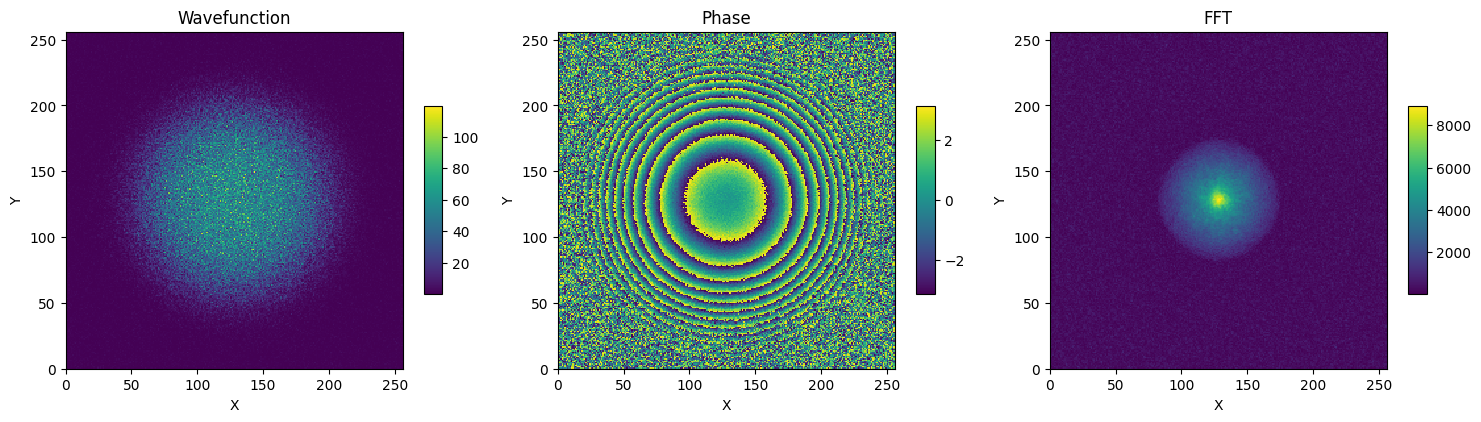

In [21]:
def load_matrix(path: str) -> np.ndarray:
    # Load the data
    data = np.loadtxt(path)
    # Extract the real and imaginary part
    re,im = data[:grid_size,:], data[grid_size:,:]
    # Combine them to a complex matrix
    psi = (re + 1j*im).reshape(grid_size,grid_size)
    return psi

# Plot Results
psi = load_matrix( os.path.join(ph.get_result_path(), "wavefunction_plus.txt") )
fft = np.fft.fftshift( np.fft.fft2(psi) )

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_title("Wavefunction")
plt_psi = ax1.pcolormesh(np.abs(psi)**2)
ax2.set_title("Phase")
plt_phase = ax2.pcolormesh(np.angle(psi))
ax3.set_title("FFT")
plt_fft = ax3.pcolormesh(np.abs(fft))

for ax,plot in zip((ax1,ax2,ax3),(plt_psi,plt_phase,plt_fft)):
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_aspect("equal")
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)

plt.tight_layout()

In [22]:
t_max = 2000  # ps; Maximum time for the simulation
pump_amps = [1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8]
monte_carlo_simulations = 5

phs={}
for amp in pump_amps:
    phs[amp]=[]
    for mc in range(monte_carlo_simulations):
        print("running for amp=",amp,"simulation ",mc+1,"of",monte_carlo_simulations)
        # Calculate unique suffix for this batch of simulations. In this case, we use the current time
        output_suffix = f"monte_carlo_t_{t_max}_mc_{mc}_amp_{amp}_{int(time.time())}"
        ph = run ( t_max = t_max, output_suffix = output_suffix, pump_amp = amp )
        phs[amp].append(ph)

running for amp= 1 simulation  1 of 5
running for amp= 1 simulation  2 of 5
running for amp= 1 simulation  3 of 5
running for amp= 1 simulation  4 of 5
running for amp= 1 simulation  5 of 5
running for amp= 1.5 simulation  1 of 5
running for amp= 1.5 simulation  2 of 5
running for amp= 1.5 simulation  3 of 5
running for amp= 1.5 simulation  4 of 5
running for amp= 1.5 simulation  5 of 5
running for amp= 2 simulation  1 of 5
running for amp= 2 simulation  2 of 5
running for amp= 2 simulation  3 of 5
running for amp= 2 simulation  4 of 5
running for amp= 2 simulation  5 of 5
running for amp= 2.5 simulation  1 of 5
running for amp= 2.5 simulation  2 of 5
running for amp= 2.5 simulation  3 of 5
running for amp= 2.5 simulation  4 of 5
running for amp= 2.5 simulation  5 of 5
running for amp= 3 simulation  1 of 5
running for amp= 3 simulation  2 of 5
running for amp= 3 simulation  3 of 5
running for amp= 3 simulation  4 of 5
running for amp= 3 simulation  5 of 5
running for amp= 3.5 simulatio

In [23]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# We will save the b values in a cache for later use
results = {}

# We apply a simple filter to only load the results of the simulations that satisfy certain conditions
filter = lambda x: f"_t_{t_max}_" in x

def load_dataset(amp: float):
    psis = np.zeros((grid_size,grid_size), dtype=np.float64)
    ffts = np.zeros((grid_size,grid_size), dtype=np.float64)
    ffts2 = np.zeros((grid_size,grid_size), dtype=np.float64)
    for monte_carlo_sim in phs[amp]:
        # Average alls Psis and their FFTs
        # List all available files
        snapshots = os.listdir( os.path.join(monte_carlo_sim.get_result_path(), "timeoutput") )
        print(f" -> Found {len(snapshots)} snapshots for simulation {monte_carlo_sim.get_result_path()}")
        # Sort them for their last element
        snapshots.sort(key=lambda x: float(x.split("_")[-1].split(".")[0]))
        for file in snapshots:
            psi = load_matrix( os.path.join(monte_carlo_sim.get_result_path(), "timeoutput", file) )
            fft = np.fft.fftshift( np.fft.fft2(psi) )
            fft = np.abs(fft * dx**2 / x_max - 0.5)**2
            psis += np.abs(psi)**2 / ( (len(snapshots)+1) * len(phs[amp]) )
            ffts += fft / ( (len(snapshots)+1) * len(phs[amp]) )
            ffts2 += fft**2 / ( (len(snapshots)+1) * len(phs[amp]) )
    return (amp, psis, ffts, ffts2)
    #results[amp] = (psis, ffts, ffts2)

# Load the datasets in parallel
with ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(load_dataset, amp) for amp in pump_amps]
    for future in as_completed(futures):
        try:
            amp, psis, ffts, ffts2 = future.result()
            results[amp] = (psis, ffts, ffts2)
        except Exception as e:
            print(f"An error occured: {e}")

 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_0_amp_1_1752530480
 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_0_amp_2.5_1752530651
 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_0_amp_1.5_1752530528
 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_0_amp_2_1752530550
 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_1_amp_2_1752530575
 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_1_amp_1.5_1752530533
 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_1_amp_2.5_1752530656
 -> Found 201 snapshots for simulation /home/robert/git/PHOENIX/examples/example_4/monte_carlo_t_2000_mc_1_amp_1_1752530509


We can plot the b cache to see the statistical variance

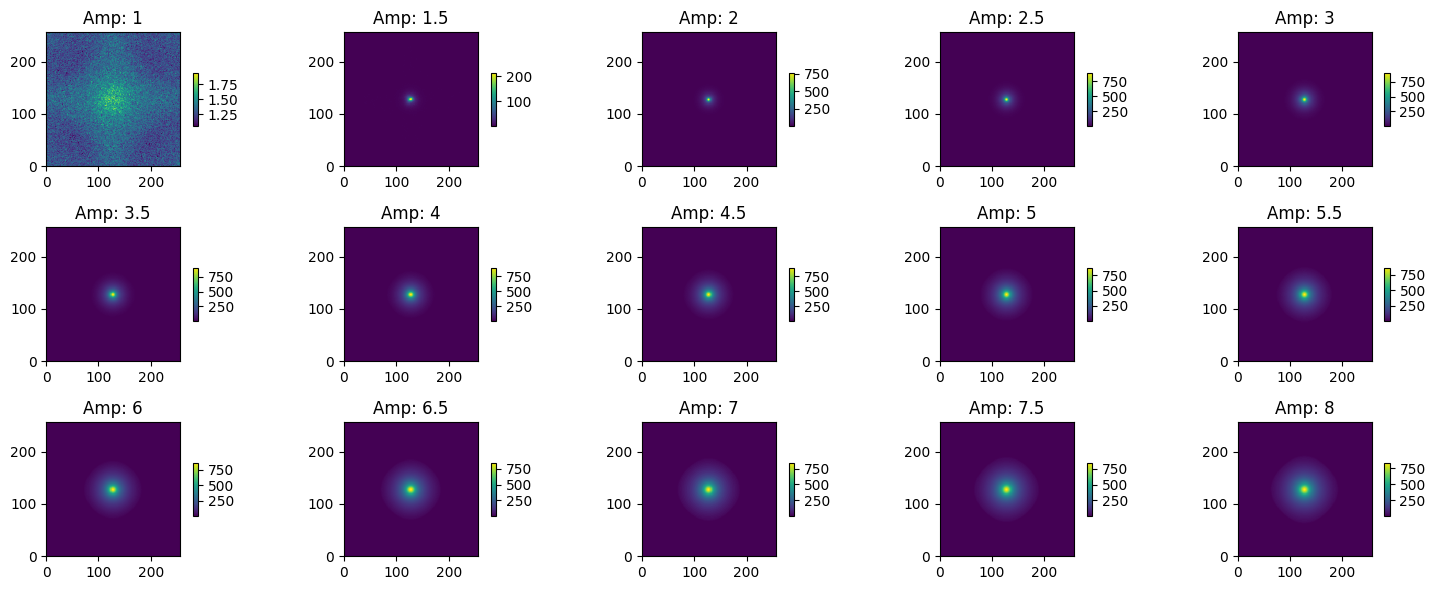

In [24]:
rows = len(results)//5 if len(results)%5 == 0 else len(results)//5 + 1
cols = np.min((len(results),5)).astype(int)
fig, axes = plt.subplots(rows,cols,figsize=(15,2*rows))
for key,ax in zip(sorted(results.keys()),axes.flatten()):
    plot = ax.pcolor( np.abs(results[key][1]), label=f"Amp: {key}")
    # colorbar
    fig.colorbar(plot, ax=ax, shrink=0.4, aspect=10)
    ax.set_aspect("equal") 
    ax.set_title(f"Amp: {key}")

plt.tight_layout()

# Calculate the Quantum Correlations

In [25]:
correlations = []

def get_center_circle(data, radius = None, threshold=10):
    center = data.shape[0]//2
    # Find radius
    if radius is None:
        radius = 1
        for i in range(center):
            if np.abs(data[center,center+i]) < threshold:
                radius = i
                break
        print(f"Radius is {radius}")
    result = []
    for i in range(center-radius, center+radius):
        for j in range(center-radius, center+radius):
            if (i-center)**2 + (j-center)**2 < radius**2:
                result.append(data[i,j])
    return np.array(result), radius

for amp, (psi,fft,fft2) in sorted(results.items(), key=lambda x: x[0]):
    
    b,radius = get_center_circle(fft)
    b2,_ = get_center_circle(fft2, radius = radius)

    N = np.prod(b.shape)

    # Expectation
    n_c = np.sum( b-0.5 )/N

    # Variance
    delta_nc = np.sum( b2 - b )/N - np.sum( (b - 0.5)**2 )/N

    # Calculate C according to https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.2.030320
    alpha02 = np.sqrt( n_c + n_c**2 - delta_nc )
    nbar = n_c - alpha02
    factor = (2*alpha02/((nbar+1)**2 - nbar**2))
    I = besselfunction(0, factor)
    C = ( 1 - np.exp( -( 2*alpha02 / ( ( nbar + 1 )**2 - nbar**2 ) ) ) * I ) / ( ( nbar + 1 )**2 - nbar**2 ) 

    #print(f"Amp: {amp}")
    #print(f"Quantum Correlation\n    {I = }\n    {factor = }\n    {nbar = }\n    {alpha02 = }\n    {n_c = }\n    {delta_nc = }")
    #print(f"C = {C}")
    correlations.append([C, n_c, delta_nc])

correlations = np.array(correlations)

Radius is 0
Radius is 15
Radius is 25
Radius is 31
Radius is 36
Radius is 40
Radius is 44
Radius is 47
Radius is 50
Radius is 52
Radius is 55
Radius is 57
Radius is 60
Radius is 62
Radius is 64


/tmp/ipykernel_1410620/1036225942.py:28: RuntimeWarning: invalid value encountered in scalar divide
  n_c = np.sum( b-0.5 )/N
/tmp/ipykernel_1410620/1036225942.py:31: RuntimeWarning: invalid value encountered in scalar divide
  delta_nc = np.sum( b2 - b )/N - np.sum( (b - 0.5)**2 )/N


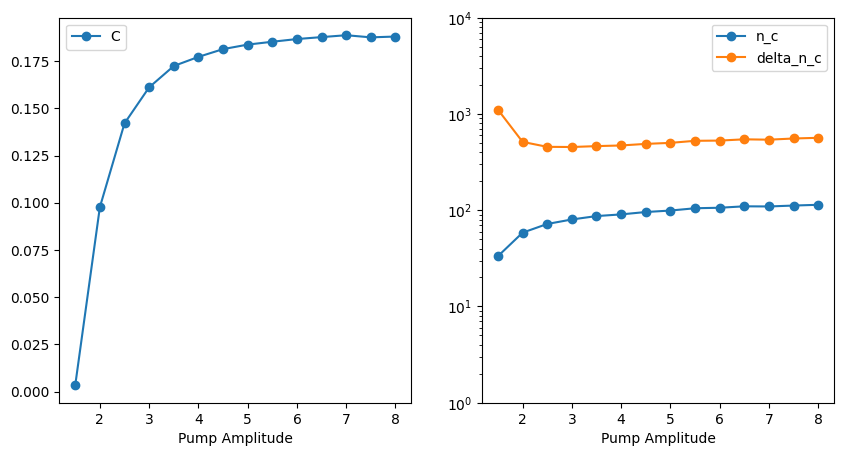

In [26]:
fig,axes = plt.subplots(1,2,figsize=(10,5))

axes[0].plot(pump_amps, correlations[:,0], "o-", label="C")
axes[1].plot(pump_amps, correlations[:,1], "o-", label="n_c")
axes[1].plot(pump_amps, correlations[:,2], "o-", label="delta_n_c")

axes[1].set_yscale("log")
axes[1].set_ylim(1,1E4)

for ax in axes:
    ax.set_xlabel("Pump Amplitude")
    ax.legend()